    Author: Nithin Akgilesh Venkat
    Date: 27.10.2021
    Topic: Cats life expectancy prediction

**Imports and Configuration**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing, linear_model, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore')

**Load Dataset**

In [2]:
df = pd.read_csv("cats.csv" , sep=',', index_col =0)
df.head()

,age at death,breed,date of last vet visit,hair length,height,number of vet visits,weight
0,7.0,Siamese,2009-08-02 14:02:18,0.883886,21.611951,5,4.0
1,9.0,Siamese,2013-11-27 19:08:52,1.221535,26.451956,10,4.0
2,8.0,Manx,2016-01-12 04:39:24,0.967718,18.540191,10,5.0
3,8.0,Maine Coon,2000-11-24 18:51:18,1.090641,16.564362,12,7.0
4,8.0,Maine Coon,2014-07-03 22:17:26,1.004712,22.535495,7,7.0


    General overall view of the dataset

In [3]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

df.info()
df.isnull().sum()

Rows     :  300
Columns  :  7

Features :  ['age at death', 'breed', 'date of last vet visit', 'hair length', 'height', 'number of vet visits', 'weight']

Missing values :   2

Unique values :  
 age at death               18
breed                       6
date of last vet visit    300
hair length               299
height                    300
number of vet visits       21
weight                     12
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age at death            299 non-null    float64
 1   breed                   300 non-null    object 
 2   date of last vet visit  300 non-null    object 
 3   hair length             299 non-null    float64
 4   height                  300 non-null    float64
 5   number of vet visits    300 non-null    int64  
 6   weight                  300 non-null    float64


age at death              1
breed                     0
date of last vet visit    0
hair length               1
height                    0
number of vet visits      0
weight                    0
dtype: int64

In [4]:
# Converting the feature names to standard format for further processing
orig_cols = list(df.columns) 
new_cols = [] 
for col in orig_cols:     
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower()) 

df.columns = new_cols



Handle Missing Values

We'll impute mean/mode values for NaN values depending on the skewness of the data

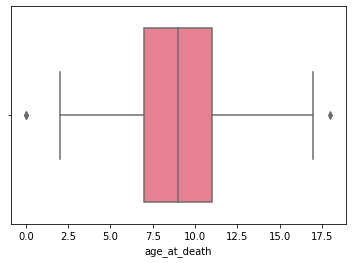

In [5]:
# filling the missing values in age and hair length features using mean nd mode values depending on the skew
sns.boxplot(df.age_at_death)

In [6]:
df['age_at_death'].fillna(value=df['age_at_death'].mean(), inplace=True)

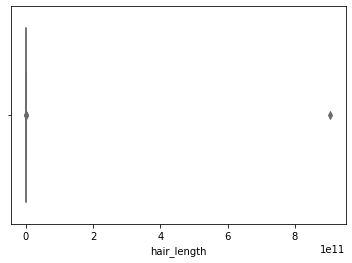

In [7]:
sns.boxplot(df.hair_length)

In [8]:
df['hair_length'] = df['hair_length'].fillna(df['hair_length'].mode()[0])

In [9]:
df.isnull().sum()

age_at_death              0
breed                     0
date_of_last_vet_visit    0
hair_length               0
height                    0
number_of_vet_visits      0
weight                    0
dtype: int64

we dont have any missing values

In [10]:
df.describe()

,age_at_death,hair_length,height,number_of_vet_visits,weight
count,300.000000,3.000000e+02,300.000000,300.000000,300.000000
mean,9.006689,3.017613e+09,20.498442,8.296667,3.957667
std,2.888095,5.226659e+10,5.107386,3.820643,2.033624
min,0.000000,6.904537e-01,5.077179,-1.000000,0.000000
25%,7.000000,9.375416e-01,16.958241,6.000000,2.000000
50%,9.000000,1.002959e+00,20.825805,8.000000,4.000000
75%,11.000000,1.066356e+00,24.043067,11.000000,5.250000
max,18.000000,9.052840e+11,33.043014,19.000000,10.000000


    The above describe() function shows us some info that needs to be fixed in the dataset before any data analysis.
    1. Fill missing values using mean/mode inputers
    2. number_vet_visits cannot be -1 
    3. weight cannot be 0 for any cat

    assigning mean values for the above criterion

In [11]:
# replacing with mean values of the column
df["number_of_vet_visits"].replace({-1: (df['number_of_vet_visits'].mean()), 0: (df['number_of_vet_visits'].mean())}, inplace=True)

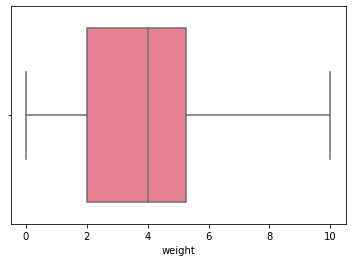

In [12]:
sns.boxplot(df.weight)

In [13]:
#  weight cannot be 0 for a cat, especially when its old. So filling them with mode value as the data is skewed
df["weight"].replace({0: (df['weight'].mean())}, inplace=True)

In [14]:
df.describe()

,age_at_death,hair_length,height,number_of_vet_visits,weight
count,300.000000,3.000000e+02,300.000000,300.000000,300.000000
mean,9.006689,3.017613e+09,20.498442,8.527911,4.089589
std,2.888095,5.226659e+10,5.107386,3.539125,1.895868
min,0.000000,6.904537e-01,5.077179,1.000000,1.000000
25%,7.000000,9.375416e-01,16.958241,6.000000,3.000000
50%,9.000000,1.002959e+00,20.825805,8.000000,4.000000
75%,11.000000,1.066356e+00,24.043067,11.000000,5.250000
max,18.000000,9.052840e+11,33.043014,19.000000,10.000000


In [15]:
# One hot encoding on categorical feature

In [16]:
# one hot encoding on categorical feature
df = pd.get_dummies(df, columns = ['breed'])
# generate binary values using get_dummies
df

,age_at_death,date_of_last_vet_visit,hair_length,height,number_of_vet_visits,weight,breed_Donald,breed_Javanese,breed_Maine Coon,breed_Manx,breed_Rex,breed_Siamese
0,7.0,2009-08-02 14:02:18,0.883886,21.611951,5.0,4.0,0,0,0,0,0,1
1,9.0,2013-11-27 19:08:52,1.221535,26.451956,10.0,4.0,0,0,0,0,0,1
2,8.0,2016-01-12 04:39:24,0.967718,18.540191,10.0,5.0,0,0,0,1,0,0
3,8.0,2000-11-24 18:51:18,1.090641,16.564362,12.0,7.0,0,0,1,0,0,0
4,8.0,2014-07-03 22:17:26,1.004712,22.535495,7.0,7.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
295,8.0,2006-01-06 11:52:45,0.878575,26.812670,14.0,1.0,0,0,0,1,0,0
296,8.0,1997-10-24 15:06:57,1.041003,16.920258,5.0,4.0,0,0,0,1,0,0
297,7.0,2008-06-06 21:09:50,1.053361,14.106118,9.0,3.0,0,0,1,0,0,0
298,15.0,1999-09-19 20:19:43,1.063393,12.210901,10.0,2.0,0,0,1,0,0,0


In [17]:
# separating month/year from the given time format

In [18]:
# df['date_of_last_vet_visit'] = df['date_of_last_vet_visit'].dt.strftime("%y/%m/%d")
df['date_of_last_vet_visit'] = pd.to_datetime(df.date_of_last_vet_visit, format='%Y-%m-%d %H:%M:%S',  errors='coerce')

In [19]:
df

,age_at_death,date_of_last_vet_visit,hair_length,height,number_of_vet_visits,weight,breed_Donald,breed_Javanese,breed_Maine Coon,breed_Manx,breed_Rex,breed_Siamese
0,7.0,2009-08-02 14:02:18,0.883886,21.611951,5.0,4.0,0,0,0,0,0,1
1,9.0,2013-11-27 19:08:52,1.221535,26.451956,10.0,4.0,0,0,0,0,0,1
2,8.0,2016-01-12 04:39:24,0.967718,18.540191,10.0,5.0,0,0,0,1,0,0
3,8.0,2000-11-24 18:51:18,1.090641,16.564362,12.0,7.0,0,0,1,0,0,0
4,8.0,2014-07-03 22:17:26,1.004712,22.535495,7.0,7.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
295,8.0,2006-01-06 11:52:45,0.878575,26.812670,14.0,1.0,0,0,0,1,0,0
296,8.0,1997-10-24 15:06:57,1.041003,16.920258,5.0,4.0,0,0,0,1,0,0
297,7.0,2008-06-06 21:09:50,1.053361,14.106118,9.0,3.0,0,0,1,0,0,0
298,15.0,1999-09-19 20:19:43,1.063393,12.210901,10.0,2.0,0,0,1,0,0,0


In [20]:
# feature engineering dividing the last vet visit
# convert date_time column to datetime type
df.date_of_last_vet_visit = pd.to_datetime(df.date_of_last_vet_visit)

In [21]:
df.dtypes

age_at_death                     float64
date_of_last_vet_visit    datetime64[ns]
hair_length                      float64
height                           float64
number_of_vet_visits             float64
weight                           float64
breed_Donald                       uint8
breed_Javanese                     uint8
breed_Maine Coon                   uint8
breed_Manx                         uint8
breed_Rex                          uint8
breed_Siamese                      uint8
dtype: object

In [22]:
# Start feature engineering
# extract month feature
months = df.date_of_last_vet_visit.dt.month

In [23]:
# extract year
years = df.date_of_last_vet_visit.dt.year

In [24]:
# features table
#first step: include features with single column nature
features = pd.DataFrame({
    'month' : months,
    'year' : years
})

features

,month,year
0,8.0,2009.0
1,11.0,2013.0
2,1.0,2016.0
3,11.0,2000.0
4,7.0,2014.0
...,...,...
295,1.0,2006.0
296,10.0,1997.0
297,6.0,2008.0
298,9.0,1999.0


In [25]:
df.drop('date_of_last_vet_visit', axis =1)

,age_at_death,hair_length,height,number_of_vet_visits,weight,breed_Donald,breed_Javanese,breed_Maine Coon,breed_Manx,breed_Rex,breed_Siamese
0,7.0,0.883886,21.611951,5.0,4.0,0,0,0,0,0,1
1,9.0,1.221535,26.451956,10.0,4.0,0,0,0,0,0,1
2,8.0,0.967718,18.540191,10.0,5.0,0,0,0,1,0,0
3,8.0,1.090641,16.564362,12.0,7.0,0,0,1,0,0,0
4,8.0,1.004712,22.535495,7.0,7.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
295,8.0,0.878575,26.812670,14.0,1.0,0,0,0,1,0,0
296,8.0,1.041003,16.920258,5.0,4.0,0,0,0,1,0,0
297,7.0,1.053361,14.106118,9.0,3.0,0,0,1,0,0,0
298,15.0,1.063393,12.210901,10.0,2.0,0,0,1,0,0,0


In [26]:
frames = [df,features]
df = pd.concat(frames, axis =1)

In [27]:
df

,age_at_death,date_of_last_vet_visit,hair_length,height,number_of_vet_visits,weight,breed_Donald,breed_Javanese,breed_Maine Coon,breed_Manx,breed_Rex,breed_Siamese,month,year
0,7.0,2009-08-02 14:02:18,0.883886,21.611951,5.0,4.0,0,0,0,0,0,1,8.0,2009.0
1,9.0,2013-11-27 19:08:52,1.221535,26.451956,10.0,4.0,0,0,0,0,0,1,11.0,2013.0
2,8.0,2016-01-12 04:39:24,0.967718,18.540191,10.0,5.0,0,0,0,1,0,0,1.0,2016.0
3,8.0,2000-11-24 18:51:18,1.090641,16.564362,12.0,7.0,0,0,1,0,0,0,11.0,2000.0
4,8.0,2014-07-03 22:17:26,1.004712,22.535495,7.0,7.0,0,0,1,0,0,0,7.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,8.0,2006-01-06 11:52:45,0.878575,26.812670,14.0,1.0,0,0,0,1,0,0,1.0,2006.0
296,8.0,1997-10-24 15:06:57,1.041003,16.920258,5.0,4.0,0,0,0,1,0,0,10.0,1997.0
297,7.0,2008-06-06 21:09:50,1.053361,14.106118,9.0,3.0,0,0,1,0,0,0,6.0,2008.0
298,15.0,1999-09-19 20:19:43,1.063393,12.210901,10.0,2.0,0,0,1,0,0,0,9.0,1999.0


In [28]:
# # Feature engineering
# Mathematical Transforms (Ratios)
# Ratios seem to be difficult for most models to learn, 
# so creating new features expressing ratio combinations can often 
# lead to some easy performance gains.
# We're going to create new features expressing important ratios using mathematical transformation:

In [29]:
age_hairlength_ratio = df['age_at_death']/df['hair_length']
age_hairlength_ratio

0       7.919571
1       7.367779
2       8.266875
3       7.335136
4       7.962479
         ...    
295     9.105649
296     7.684898
297     6.645395
298    14.105792
299     9.142277
Length: 300, dtype: float64

In [30]:
age_height_ratio = df['age_at_death']/df['height']

In [31]:
age_weight_ratio = df['age_at_death']/df['weight']

In [32]:
age_vetvisits_ratio = df['age_at_death']/df['number_of_vet_visits']

In [33]:
height_weight_ratio = df['height']/df['weight']

In [34]:
height_hair_ratio = df['height']/df['hair_length']

In [35]:
weight_hair_ratio = df['weight']/df['hair_length']

In [36]:
# new features table
#first step: include features with single column nature
new_features = pd.DataFrame({
    'age_height_ratio' : age_height_ratio,
    'age_weight_ratio' : age_weight_ratio,
    'age_vetvisits_ratio' : age_vetvisits_ratio,
    'height_weight_ratio' : height_weight_ratio,
    'height_hair_ratio' : height_hair_ratio,
    'weight_hair_ratio' : weight_hair_ratio })

new_features

,age_height_ratio,age_weight_ratio,age_vetvisits_ratio,height_weight_ratio,height_hair_ratio,weight_hair_ratio
0,0.323895,1.750000,1.400000,5.402988,24.451054,4.525469
1,0.340239,2.250000,0.900000,6.612989,21.654684,3.274568
2,0.431495,1.600000,0.800000,3.708038,19.158681,5.166797
3,0.482965,1.142857,0.666667,2.366337,15.187730,6.418244
4,0.354996,1.142857,1.142857,3.219356,22.429800,6.967169
...,...,...,...,...,...,...
295,0.298366,8.000000,0.571429,26.812670,30.518346,1.138206
296,0.472806,2.000000,1.600000,4.230065,16.253807,3.842449
297,0.496239,2.333333,0.777778,4.702039,13.391532,2.848026
298,1.228411,7.500000,1.500000,6.105450,11.482962,1.880772


In [37]:
new_frames = [df,new_features]
df = pd.concat(new_frames, axis =1)

In [38]:
df

,age_at_death,date_of_last_vet_visit,hair_length,height,number_of_vet_visits,weight,breed_Donald,breed_Javanese,breed_Maine Coon,breed_Manx,breed_Rex,breed_Siamese,month,year,age_height_ratio,age_weight_ratio,age_vetvisits_ratio,height_weight_ratio,height_hair_ratio,weight_hair_ratio
0,7.0,2009-08-02 14:02:18,0.883886,21.611951,5.0,4.0,0,0,0,0,0,1,8.0,2009.0,0.323895,1.750000,1.400000,5.402988,24.451054,4.525469
1,9.0,2013-11-27 19:08:52,1.221535,26.451956,10.0,4.0,0,0,0,0,0,1,11.0,2013.0,0.340239,2.250000,0.900000,6.612989,21.654684,3.274568
2,8.0,2016-01-12 04:39:24,0.967718,18.540191,10.0,5.0,0,0,0,1,0,0,1.0,2016.0,0.431495,1.600000,0.800000,3.708038,19.158681,5.166797
3,8.0,2000-11-24 18:51:18,1.090641,16.564362,12.0,7.0,0,0,1,0,0,0,11.0,2000.0,0.482965,1.142857,0.666667,2.366337,15.187730,6.418244
4,8.0,2014-07-03 22:17:26,1.004712,22.535495,7.0,7.0,0,0,1,0,0,0,7.0,2014.0,0.354996,1.142857,1.142857,3.219356,22.429800,6.967169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,8.0,2006-01-06 11:52:45,0.878575,26.812670,14.0,1.0,0,0,0,1,0,0,1.0,2006.0,0.298366,8.000000,0.571429,26.812670,30.518346,1.138206
296,8.0,1997-10-24 15:06:57,1.041003,16.920258,5.0,4.0,0,0,0,1,0,0,10.0,1997.0,0.472806,2.000000,1.600000,4.230065,16.253807,3.842449
297,7.0,2008-06-06 21:09:50,1.053361,14.106118,9.0,3.0,0,0,1,0,0,0,6.0,2008.0,0.496239,2.333333,0.777778,4.702039,13.391532,2.848026
298,15.0,1999-09-19 20:19:43,1.063393,12.210901,10.0,2.0,0,0,1,0,0,0,9.0,1999.0,1.228411,7.500000,1.500000,6.105450,11.482962,1.880772


In [39]:
df.dtypes

age_at_death                     float64
date_of_last_vet_visit    datetime64[ns]
hair_length                      float64
height                           float64
number_of_vet_visits             float64
weight                           float64
breed_Donald                       uint8
breed_Javanese                     uint8
breed_Maine Coon                   uint8
breed_Manx                         uint8
breed_Rex                          uint8
breed_Siamese                      uint8
month                            float64
year                             float64
age_height_ratio                 float64
age_weight_ratio                 float64
age_vetvisits_ratio              float64
height_weight_ratio              float64
height_hair_ratio                float64
weight_hair_ratio                float64
dtype: object

In [40]:

# locate rows of duplicate data
# calculate duplicates
dups = df.duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(df[dups])

False
Empty DataFrame
Columns: [age_at_death, date_of_last_vet_visit, hair_length, height, number_of_vet_visits, weight, breed_Donald, breed_Javanese, breed_Maine Coon, breed_Manx, breed_Rex, breed_Siamese, month, year, age_height_ratio, age_weight_ratio, age_vetvisits_ratio, height_weight_ratio, height_hair_ratio, weight_hair_ratio]
Index: []


In [41]:
# df.drop('date_of_last_vet_visit', axis=1)
df.drop('date_of_last_vet_visit', axis=1, inplace=True)

In [42]:
df

,age_at_death,hair_length,height,number_of_vet_visits,weight,breed_Donald,breed_Javanese,breed_Maine Coon,breed_Manx,breed_Rex,breed_Siamese,month,year,age_height_ratio,age_weight_ratio,age_vetvisits_ratio,height_weight_ratio,height_hair_ratio,weight_hair_ratio
0,7.0,0.883886,21.611951,5.0,4.0,0,0,0,0,0,1,8.0,2009.0,0.323895,1.750000,1.400000,5.402988,24.451054,4.525469
1,9.0,1.221535,26.451956,10.0,4.0,0,0,0,0,0,1,11.0,2013.0,0.340239,2.250000,0.900000,6.612989,21.654684,3.274568
2,8.0,0.967718,18.540191,10.0,5.0,0,0,0,1,0,0,1.0,2016.0,0.431495,1.600000,0.800000,3.708038,19.158681,5.166797
3,8.0,1.090641,16.564362,12.0,7.0,0,0,1,0,0,0,11.0,2000.0,0.482965,1.142857,0.666667,2.366337,15.187730,6.418244
4,8.0,1.004712,22.535495,7.0,7.0,0,0,1,0,0,0,7.0,2014.0,0.354996,1.142857,1.142857,3.219356,22.429800,6.967169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,8.0,0.878575,26.812670,14.0,1.0,0,0,0,1,0,0,1.0,2006.0,0.298366,8.000000,0.571429,26.812670,30.518346,1.138206
296,8.0,1.041003,16.920258,5.0,4.0,0,0,0,1,0,0,10.0,1997.0,0.472806,2.000000,1.600000,4.230065,16.253807,3.842449
297,7.0,1.053361,14.106118,9.0,3.0,0,0,1,0,0,0,6.0,2008.0,0.496239,2.333333,0.777778,4.702039,13.391532,2.848026
298,15.0,1.063393,12.210901,10.0,2.0,0,0,1,0,0,0,9.0,1999.0,1.228411,7.500000,1.500000,6.105450,11.482962,1.880772


In [43]:
df["month"].fillna(0, inplace = True)

In [44]:
df["year"].fillna(0, inplace = True)

    A heatmap is a graphical representation where individual values of a matrix are represented as colors. A heatmap is very useful in visualizing the concentration of values between two dimensions of a matrix. This helps in finding patterns and gives a perspective of depth.

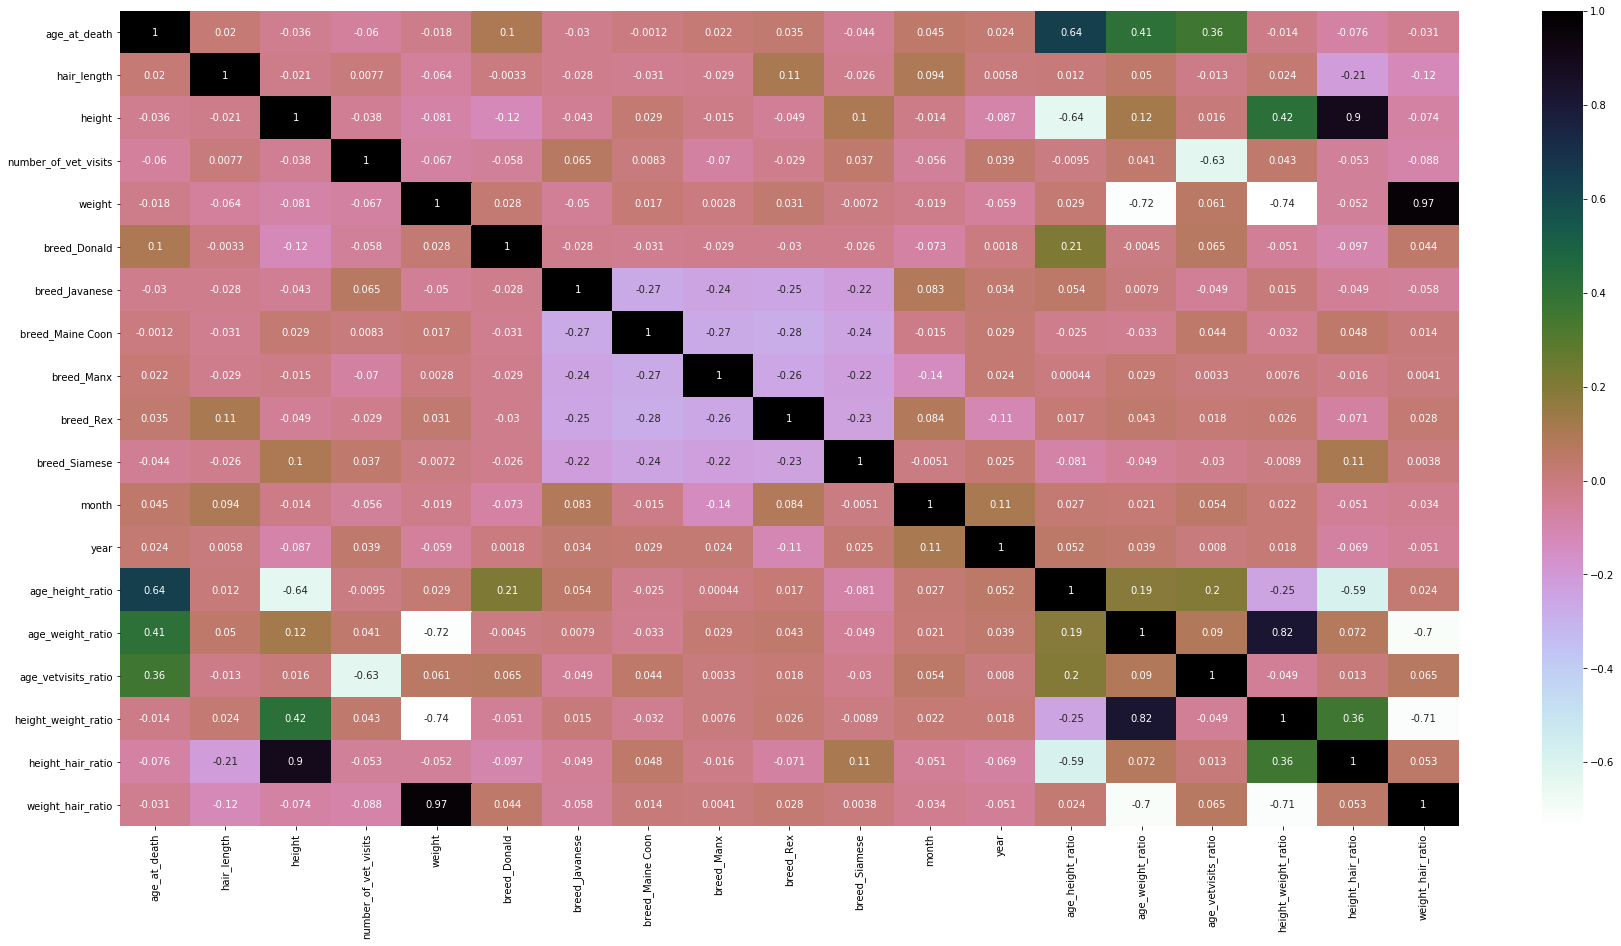

In [45]:
# heatmap
plt.figure(figsize=(30,15))
sns.heatmap(df.corr(), annot=True, cmap='cubehelix_r')
plt.show()

<Figure size 1080x1080 with 0 Axes>

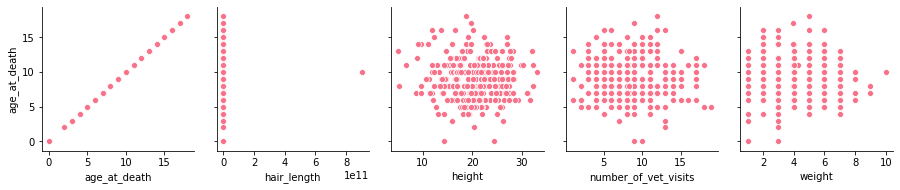

<Figure size 1080x1080 with 0 Axes>

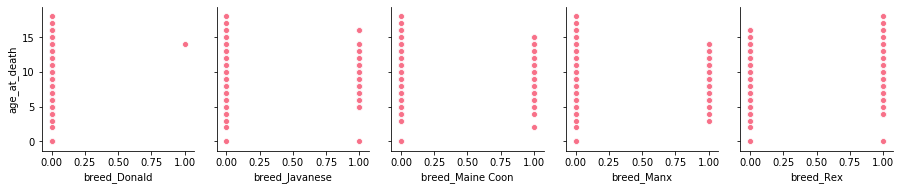

<Figure size 1080x1080 with 0 Axes>

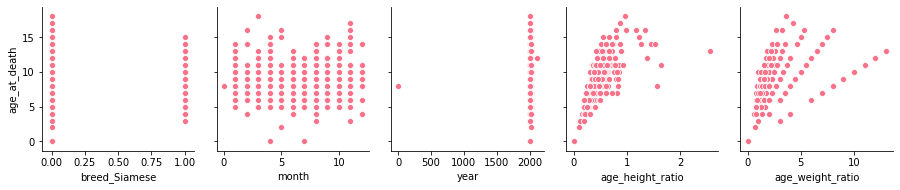

<Figure size 1080x1080 with 0 Axes>

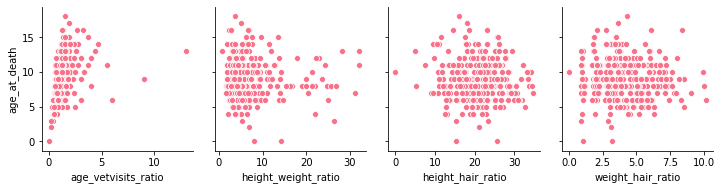

In [46]:
for i in range(0, len(df.columns), 5):
    plt.figure(figsize=(15,15))
    sns.pairplot(data=df, x_vars=df.columns[i:i+5], y_vars=['age_at_death'])

In [47]:
# above plot is to check for any outliers in our most correlated features. looks good for data modelling

In [48]:
# ExtraTreesdClassifier is used to find the feature importance for data modelling. Using less prominent feature is useless.

In [49]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib as plt

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age_at_death          300 non-null    float64
 1   hair_length           300 non-null    float64
 2   height                300 non-null    float64
 3   number_of_vet_visits  300 non-null    float64
 4   weight                300 non-null    float64
 5   breed_Donald          300 non-null    uint8  
 6   breed_Javanese        300 non-null    uint8  
 7   breed_Maine Coon      300 non-null    uint8  
 8   breed_Manx            300 non-null    uint8  
 9   breed_Rex             300 non-null    uint8  
 10  breed_Siamese         300 non-null    uint8  
 11  month                 300 non-null    float64
 12  year                  300 non-null    float64
 13  age_height_ratio      300 non-null    float64
 14  age_weight_ratio      300 non-null    float64
 15  age_vetvisits_ratio   3

In [51]:
# from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor(n_estimators=5, max_depth=10, max_features=0.3, n_jobs=-1, random_state=0)

In [52]:
X = df.drop(['age_at_death'], axis=1)
y = df['age_at_death']
print(f'X shape: {X.shape} | y shape: {y.shape} ')

X shape: (300, 18) | y shape: (300,) 


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train

,hair_length,height,number_of_vet_visits,weight,breed_Donald,breed_Javanese,breed_Maine Coon,breed_Manx,breed_Rex,breed_Siamese,month,year,age_height_ratio,age_weight_ratio,age_vetvisits_ratio,height_weight_ratio,height_hair_ratio,weight_hair_ratio
158,0.995056,25.690748,9.0,3.000000,0,0,0,1,0,0,6.0,2000.0,0.311396,2.666667,0.888889,8.563583,25.818404,3.014907
150,1.056595,21.701264,9.0,6.000000,0,0,0,0,1,0,3.0,2000.0,0.414722,1.500000,1.000000,3.616877,20.538859,5.678616
102,1.086447,19.750088,9.0,3.957667,0,0,0,0,1,0,11.0,2007.0,0.860756,4.295460,1.888889,4.990336,18.178608,3.642762
163,1.096407,22.907829,7.0,3.957667,0,0,1,0,0,0,4.0,2000.0,0.611145,3.537438,2.000000,5.788216,20.893537,3.609668
112,1.177806,18.161187,7.0,2.000000,0,0,1,0,0,0,4.0,2010.0,0.330375,3.000000,0.857143,9.080594,15.419505,1.698072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,1.048410,21.556537,10.0,4.000000,0,0,0,1,0,0,3.0,1999.0,0.556676,3.000000,1.200000,5.389134,20.561172,3.815302
255,1.023265,9.722051,11.0,6.000000,0,0,1,0,0,0,3.0,2001.0,0.720013,1.166667,0.636364,1.620342,9.501014,5.863586
72,1.007573,20.862113,6.0,7.000000,0,0,0,0,0,1,2.0,2015.0,0.479338,1.428571,1.666667,2.980302,20.705313,6.947388
235,0.947216,18.435191,10.0,5.000000,0,0,1,0,0,0,3.0,2014.0,0.650929,2.400000,1.200000,3.687038,19.462492,5.278625


In [54]:
model.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=10, max_features=0.3, n_estimators=5, n_jobs=-1,
                    random_state=0)

In [55]:
model.feature_importances_

array([0.01447215, 0.04574156, 0.03637405, 0.03592201, 0.00682695,
       0.00688846, 0.00655886, 0.00845922, 0.01321074, 0.00874726,
       0.01059432, 0.00790883, 0.46710696, 0.073751  , 0.14687813,
       0.01868349, 0.05704253, 0.03483348])

In [56]:
rf = pd.Series(model.feature_importances_ , index = X_train.columns)

In [57]:
rf = pd.DataFrame(model.feature_importances_ , index = X_train.columns)
rf

,0
hair_length,0.014472
height,0.045742
number_of_vet_visits,0.036374
weight,0.035922
breed_Donald,0.006827
breed_Javanese,0.006888
breed_Maine Coon,0.006559
breed_Manx,0.008459
breed_Rex,0.013211
breed_Siamese,0.008747


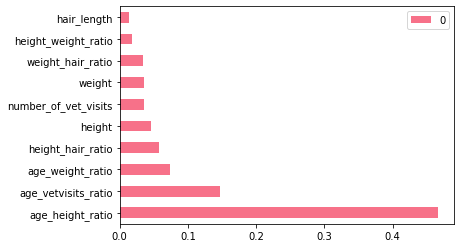

In [58]:
rf.nlargest(10,rf).plot(kind = 'barh')

In [59]:
# from the above plot we can see that 'age_height_ratio', 'age_vetvisits_ratio', 'age_weight_ratio' are the most important features

In [60]:
# Data Modelling

# Mode1: Linear Regression

In [61]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Take the the values of the target variable and of the most correlated feature with the target variable.
le_features = df['age_height_ratio'].values.reshape(-1,1)
le_labels = df['age_at_death'].values.reshape(-1,1)

# Normalize the data.
min_max_scaler = MinMaxScaler()
le_features = min_max_scaler.fit_transform(le_features)

# Split the dataset in training and test set.
# Splitting our dataset into train and test using train_test_split(), 
# what we are doing here is taking 80% of data to train our model, 
# and 20% that we will hold back as a validation dataset:
le_features_train, le_features_test, le_labels_train, le_labels_test = train_test_split(le_features, le_labels, train_size = 0.7, test_size = 0.3)

In [62]:
linear_model = LinearRegression()

# Train the model.
linear_model.fit(le_features_train, le_labels_train);

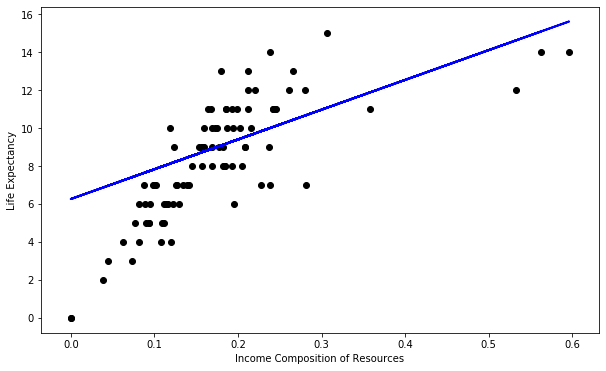

Coefficients: 
 [[15.69291029]]
Mean squared error: 5.16
R^2 score : 0.45


In [63]:
# Test the model.
linear_model_score = linear_model.predict(le_features_test)

# Plot the result.
plt.figure(figsize=(10, 6))
plt.scatter(le_features_test, le_labels_test,  color='black')
plt.plot(le_features_test, linear_model_score, color='blue', linewidth=2)
plt.xlabel('Income Composition of Resources')
plt.ylabel('Life Expectancy')
plt.show()

print('Coefficients: \n', linear_model.coef_)
print("Mean squared error: %.2f" % mean_squared_error(le_labels_test,linear_model_score))
print("R^2 score : %.2f" % r2_score(le_labels_test,linear_model_score))

- Multiple Linear Regression

In [64]:

# Separate the features from the labels.
le_features = df[['age_height_ratio', 'age_vetvisits_ratio', 'age_weight_ratio']]
le_labels = df['age_at_death']
# Normalize the data.
min_max_scaler = MinMaxScaler()
le_features = min_max_scaler.fit_transform(le_features)

# Split the dataset in training and test set.
le_features_train, le_features_test, le_labels_train, le_labels_test = train_test_split(le_features, le_labels, train_size = 0.7, test_size = 0.3)

In [65]:
# Train the model.
linear_model.fit(le_features_train, le_labels_train);

# Test the model.
linear_model_score = linear_model.predict(le_features_test)

print('Coefficients: \n', linear_model.coef_)
print("Mean squared error: %.2f" % mean_squared_error(le_labels_test,linear_model_score))
print("R^2 score : %.2f" % r2_score(le_labels_test,linear_model_score))

Coefficients: 
 [15.41557227  7.9410616   4.31453105]
Mean squared error: 3.92
R^2 score : 0.52


- Logistic Regression

In [66]:
# Calculate the life expeectancy average
le_avg = df['age_at_death'].mean()
le_lr = df.copy()

# Replace 1 if life expectancy > avg, 0 otherwise
le_lr['age_at_death'] = (le_lr['age_at_death'] > le_avg).astype(int)

# Separate the features from the labels.
le_features_lr = le_lr.iloc[:, 1:].values
le_labels_lr = le_lr.iloc[:,0] #age_at_death

# Normalize the data.
min_max_scaler = MinMaxScaler()
le_features_lr = min_max_scaler.fit_transform(le_features_lr)

# Split the dataset in training and test set.
le_features_train_lr, le_features_test_lr, le_labels_train_lr, le_labels_test_lr = train_test_split(le_features_lr, le_labels_lr, train_size = 0.7, test_size = 0.3)

In [67]:
logistic_model = LogisticRegression(solver='liblinear')

#Train The Model
logistic_model.fit(le_features_train_lr, le_labels_train_lr);

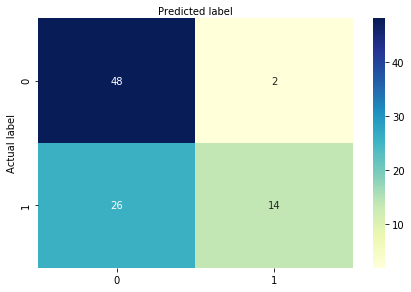

In [68]:
logistic_score = logistic_model.predict(le_features_test_lr)

#Perform confusion matrix
confusion_matrix = confusion_matrix(le_labels_test_lr, logistic_score)

#Print confusion matrix as heatmap
class_names=[0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix),cmap='YlGnBu',annot=True,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

In [69]:
print("Score on the train data: %.2f" % logistic_model.score(le_features_train_lr, le_labels_train_lr))
print("Score on the test data: %.2f" % logistic_model.score(le_features_test_lr, le_labels_test_lr))


Score on the train data: 0.74
Score on the test data: 0.69


- Decision Tree

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
# Perform DecisionTreeRegresson with three different depths
decision_tree_model3 = DecisionTreeRegressor(max_depth=3)
decision_tree_model5 = DecisionTreeRegressor(max_depth=5)
decision_tree_model7 = DecisionTreeRegressor(max_depth=7)

# Train the model.
decision_tree_model3 = decision_tree_model3.fit(le_features_train, le_labels_train)
decision_tree_model5 = decision_tree_model5.fit(le_features_train, le_labels_train)
decision_tree_model7 = decision_tree_model7.fit(le_features_train, le_labels_train)

print("Score on the train data with depth 3: %.2f" % decision_tree_model3.score(le_features_train, le_labels_train))
print("Score on the test data with depth 3: %.2f" % decision_tree_model3.score(le_features_test, le_labels_test))
print("Score on the train data with depth 5: %.2f" % decision_tree_model5.score(le_features_train, le_labels_train))
print("Score on the test data with depth 5: %.2f" % decision_tree_model5.score(le_features_test, le_labels_test))
print("Score on the train data with depth 7: %.2f" % decision_tree_model7.score(le_features_train, le_labels_train))
print("Score on the test data with depth 7: %.2f" % decision_tree_model7.score(le_features_test, le_labels_test))

Score on the train data with depth 3: 0.76
Score on the test data with depth 3: 0.59
Score on the train data with depth 5: 0.85
Score on the test data with depth 5: 0.70
Score on the train data with depth 7: 0.93
Score on the test data with depth 7: 0.69


- Random Forest

In [71]:
random_forest_model = RandomForestRegressor(n_estimators=100,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

# Train the model.
random_forest_model.fit(le_features_train, le_labels_train);

In [72]:
# Test the model.
random_forest_score = random_forest_model.predict(le_features_test)

print("Score on the train data: %.2f" % random_forest_model.score(le_features_train, le_labels_train))
print("Score on the test data: %.2f" % random_forest_model.score(le_features_test, le_labels_test))


Score on the train data: 0.89
Score on the test data: 0.72


In [73]:
output = pd.DataFrame({'Age_at_death': le_labels_test, 'Life_expectancy': random_forest_score})
output

,Age_at_death,Life_expectancy
289,10.0,8.196677
138,8.0,8.733798
94,6.0,5.009627
247,6.0,7.621535
256,8.0,8.219438
...,...,...
124,6.0,7.091278
203,12.0,11.080540
73,9.0,9.331405
92,7.0,9.763700


In [74]:
# We can see that Random forest algorithm is performing better for this dataset. 
# Hence, final prediction is tabulated with Random forest model predictions.

**End of document**